In [67]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

The RNN training parts of this notebook are based on the following:

https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3

In [124]:
### functions

sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(y_test, pred, labels=None):

    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [3]:
df_train = pd.read_csv('../../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)

df_test = pd.read_csv('../../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"['see', 'movies', 'paper', 'tv', 'news', 'some...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"['old', 'know', 'old', 'say', 'reconsider', 's...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"['thats', 'way', 'aha', 'aha', 'like', 'aha', ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"['electric', 'cant', 'see', 'electric', 'got',...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"['cant', 'get', 'satisfaction', 'cant', 'get',...","[cant, get, satisfaction, cant, get, satisfact..."


In [5]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
GLOVE_MODELS = {}

for dim in ["100d"]:#["50d", "100d", "200d", "300d"]:
    glove_path = f"../../glove/glove.6B.{dim}.txt"
    glove_word2vec_path = glove_path + '.word2vec'

    if os.path.exists(glove_word2vec_path):
        # load the Stanford GloVe model
        print(f"Loading saved glove word2vec {dim} model")
        GLOVE_MODELS[dim] = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
    else:
        # load the Stanford GloVe model from txt file, convert to word2vec and save
        print(f"Creating glove word2vec {dim} model")
        glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        glove_model.save_word2vec_format(glove_word2vec_path)
        GLOVE_MODELS[dim] = glove_model

print(GLOVE_MODELS)

Loading saved glove word2vec 100d model
{'100d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f0d90f23640>}


In [6]:
# Show a word embedding
print('King: ', GLOVE_MODELS["100d"].get_vector('king'))

# Show a similar word
similar_word = GLOVE_MODELS["100d"].most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('Most similar word to King + Woman: ', similar_word)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

In [7]:
from sklearn.base import BaseEstimator

# create vectorizer that uses glove embeddings
class LyricsVectorizer(BaseEstimator):
    def __init__(self, word_vec_dim="100d", method="mean"):
        self.word_vectors = GLOVE_MODELS[word_vec_dim]
        self.word_vec_dim = word_vec_dim
        self.method = method

    def fit(self, X, y=None):
        return self

    def _transform(self, data):
        # determine the dimensionality of vectors
        vec = np.zeros(self.word_vectors.vector_size)
        
        if type(data) == list:
            #print("Data is tokenized")
            tokenized = True
        elif type(data) == str:
            #print("Data is non-tokenized string")
            tokenized = False
        else:
            print("Not recognized data type")
            return None
        
        if tokenized:
            tokens = data
        else:
            tokens = data.split()
        vecs = []
        for word in tokens:
            try:
                # throws KeyError if word not found
                word_embed = self.word_vectors.get_vector(word)
                vecs.append(word_embed)
            except KeyError:
                pass
        if len(vecs) > 0:
            vecs = np.array(vecs)
            if self.method == "mean":
                vec = vecs.mean(axis=0) # lyrics embedding = mean over all words
            else:
                vec = vecs.sum(axis=0) # lyrics embedding = sum over all words
            # maybe consider concatenation?
        return vec
    
    def transform(self, X):
        return np.concatenate(
            [self._transform(row).reshape(1, -1) for row in X]
            )
    
    def get_params(self, deep=True):
        result = {"word_vec_dim": self.word_vec_dim, "method": self.method}
        return result

In [58]:
from sklearn.preprocessing import LabelBinarizer

# Renaming, Input -> X, Output -> y
#X_tf_train = df_train['lyrics']
#X_tf_test = df_test['lyrics']
X_tf_train = df_train['lemmatized'].apply(' '.join)
X_tf_test = df_test['lemmatized'].apply(' '.join)

# Convert labels into a one-hot vector (length = number of genres)
lab = LabelBinarizer()
lab.fit(df_train['genre'])
y_tf_train = lab.transform(df_train['genre'])
y_tf_test = lab.transform(df_test['genre'])

# Example (you can modify n)
print('Coding of labels into a one-hot vector, e.g.: ')
print(df_train['genre'][0], '->', y_tf_train[0])
print(df_train['genre'][1], ' ->', y_tf_train[1])
print(df_train['genre'][2], '  ->', y_tf_train[2])

Coding of labels into a one-hot vector, e.g.: 
country -> [0 1 0 0 0 0 0 0]
reggae  -> [0 0 0 0 0 0 1 0]
disco   -> [0 0 1 0 0 0 0 0]


In [59]:
corpus = X_tf_train
max_words = 20000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [141]:
max_len = 300

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=0 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print('Example: ',X_tf_train_seq[n,:])

Shape:  (609, 300)
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

In [142]:
glove = GLOVE_MODELS["100d"]
corpus_len = len(reverse_voc)
emb_matrix=np.zeros((corpus_len+1, glove.vector_size))

for i in range(corpus_len):
    w = reverse_voc[i+1]
    try:
        # throws KeyError if word not found
        #word_embed = 
        emb_matrix[i+1,:] = glove.get_vector(w)
    except KeyError:
        pass
    
emb_size = emb_matrix.shape[1]
print(emb_matrix.shape)

(7660, 100)


In [186]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape, name='input')

# Embedding layer (voc size plus pad token (with index 0), using the pre-trained emb_matrix obtained from glove
x = layers.Embedding(corpus_len+1, emb_size, weights=[emb_matrix], trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(32,dropout=0.2,return_sequences=True), name='bidirectional-lstm1')(x) 
x = layers.Bidirectional(layers.LSTM(64,dropout=0.2), name='bidirectional-lstm2')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(128, activation='relu', name='dense')(x)
output = layers.Dense(df_train['genre'].nunique(), activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [187]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 100)          766000    
                                                                 
 bidirectional-lstm1 (Bidire  (None, 300, 64)          34048     
 ctional)                                                        
                                                                 
 bidirectional-lstm2 (Bidire  (None, 128)              66048     
 ctional)                                                        
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               165

In [195]:
best = sorted(os.listdir("100d_model/"))[-1]
model = tf.keras.models.load_model(f"100d_model/{best}")

start_time = datetime.now()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="100d_model/{val_accuracy:.3f}_acc",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=16, shuffle=True, epochs=10, callbacks=[checkpoint_cb], validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8900

INFO:tensorflow:Assets written to: 100d_model/0.418_acc/assets


INFO:tensorflow:Assets written to: 100d_model/0.418_acc/assets


39/39 [==============================] - 30s 624ms/step - loss: 0.3057 - accuracy: 0.8900 - val_loss: 2.5886 - val_accuracy: 0.4183
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9475

INFO:tensorflow:Assets written to: 100d_model/0.451_acc/assets


INFO:tensorflow:Assets written to: 100d_model/0.451_acc/assets


39/39 [==============================] - 25s 659ms/step - loss: 0.1825 - accuracy: 0.9475 - val_loss: 2.6391 - val_accuracy: 0.4510
Epoch 3/10
39/39 [==============================] - 9s 242ms/step - loss: 0.1580 - accuracy: 0.9458 - val_loss: 2.7201 - val_accuracy: 0.4510
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9475

INFO:tensorflow:Assets written to: 100d_model/0.477_acc/assets


INFO:tensorflow:Assets written to: 100d_model/0.477_acc/assets


39/39 [==============================] - 27s 697ms/step - loss: 0.1701 - accuracy: 0.9475 - val_loss: 2.7556 - val_accuracy: 0.4771
Epoch 5/10
39/39 [==============================] - 10s 245ms/step - loss: 0.2070 - accuracy: 0.9409 - val_loss: 2.7815 - val_accuracy: 0.4641
Epoch 6/10
39/39 [==============================] - 10s 252ms/step - loss: 0.2498 - accuracy: 0.9212 - val_loss: 2.7004 - val_accuracy: 0.4641
Epoch 7/10
39/39 [==============================] - 10s 252ms/step - loss: 0.2346 - accuracy: 0.9261 - val_loss: 3.0097 - val_accuracy: 0.4706
Epoch 8/10
39/39 [==============================] - 11s 277ms/step - loss: 0.2813 - accuracy: 0.9097 - val_loss: 2.8736 - val_accuracy: 0.4444
Epoch 9/10
39/39 [==============================] - 11s 278ms/step - loss: 0.1913 - accuracy: 0.9343 - val_loss: 2.9994 - val_accuracy: 0.4314
Epoch 10/10
39/39 [==============================] - 11s 283ms/step - loss: 0.1522 - accuracy: 0.9557 - val_loss: 3.0181 - val_accuracy: 0.4379



Best Accuracy Training data:  95.24%
Best Accuracy Test data:      49.67%
Training time: 585.3 sec


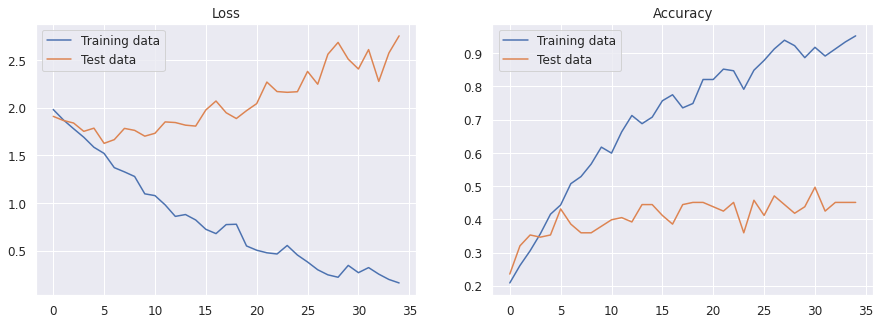

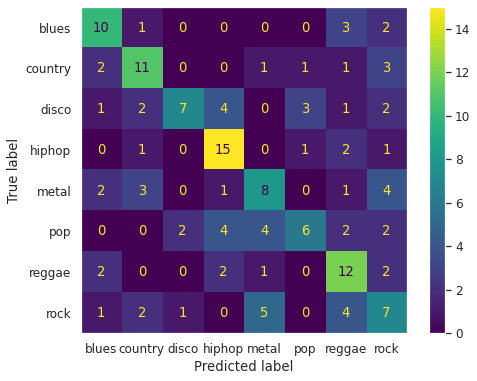

Accuracy  = 0.49673202614379086
F1 score  = 0.4894994885112092
Precision = 0.5140041086758904
Recall    = 0.49673202614379086


In [193]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper left")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="upper left")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Best Accuracy Training data:  {:.2%}'.format(max(history.history['accuracy'])))
print('Best Accuracy Test data:      {:.2%}'.format(max(history.history['val_accuracy'])))
print('Training time: {:.1f} sec'.format(training_time_rnn))

best = sorted(os.listdir("100d_model/"))[-1]
best_model = tf.keras.models.load_model(f"100d_model/{best}")
pred_prob = best_model.predict(X_tf_test_seq)
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)

## Bayes

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV score = 0.389 with the following parameters:
{'clf__var_smoothing': 1e-11, 'vec__method': 'mean'}


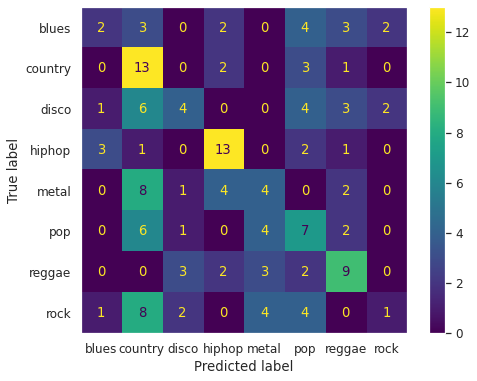

Accuracy  = 0.3464052287581699
F1 score  = 0.3167530524907191
Precision = 0.3348466127664763
Recall    = 0.3464052287581699


In [45]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('clf', GaussianNB())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV score = 0.389 with the following parameters:
{'clf__var_smoothing': 1e-11, 'vec__method': 'mean'}


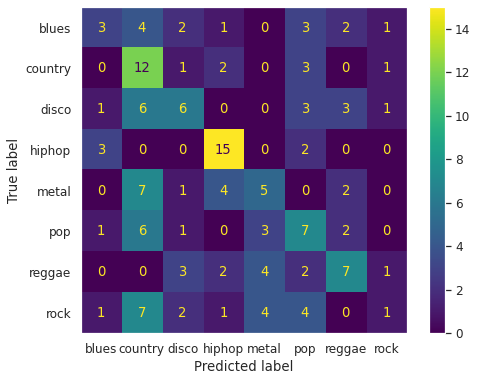

Accuracy  = 0.3660130718954248
F1 score  = 0.3418798537795645
Precision = 0.3551976346093993
Recall    = 0.3660130718954248


In [ ]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('clf', GaussianNB())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

## Random Forest Classifier

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.471 with the following parameters:
{'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'clf__random_state': 12345, 'vec__method': 'sum'}


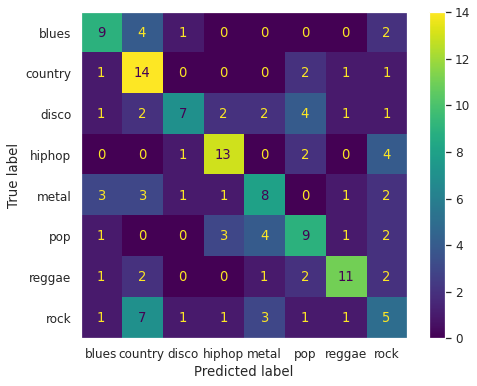

Accuracy  = 0.49673202614379086
F1 score  = 0.49332144985677745
Precision = 0.5116370150441054
Recall    = 0.49673202614379086


In [52]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'vec__method':["mean", "sum"],
    'clf__n_estimators': [50, 100, 500, 1000],
    'clf__max_depth': [3, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__random_state': [RANDOM_STATE]
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.476 with the following parameters:
{'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 500, 'clf__random_state': 12345, 'vec__method': 'sum'}


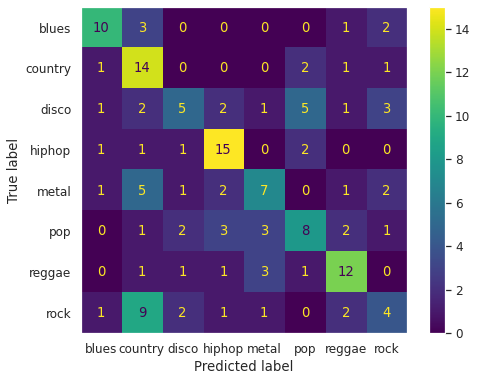

Accuracy  = 0.49019607843137253
F1 score  = 0.4749480139763948
Precision = 0.48495614770124584
Recall    = 0.49019607843137253


In [53]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'vec__method':["mean", "sum"],
    'clf__n_estimators': [50, 100, 500, 1000],
    'clf__max_depth': [3, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__random_state': [RANDOM_STATE]
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

## SVM

In [54]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('clf', SVC())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['auto', 'scale', 0.1, 0.001],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [55]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('clf', SVC())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['auto', 'scale', 0.1, 0.001],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


KeyboardInterrupt: 

## XGBoost

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.481 with the following parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'vec__method': 'sum'}


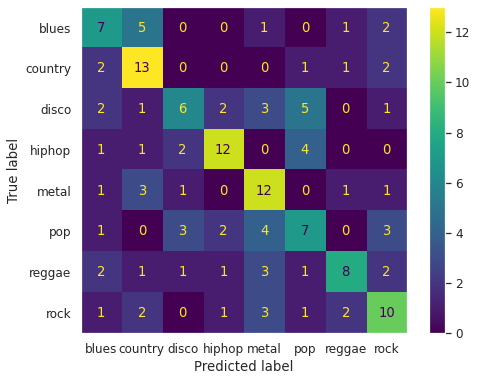

Accuracy  = 0.49019607843137253
F1 score  = 0.4852214435264601
Precision = 0.4967719404980378
Recall    = 0.49019607843137253


In [56]:
# 100 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("100d")),
    ('clf', XGBClassifier())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__max_depth': [3, 6, 10],
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__learning_rate': [0.01, 0.1, 0.2],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train_enc)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test, label_enc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV score = 0.460 with the following parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__method': 'mean'}


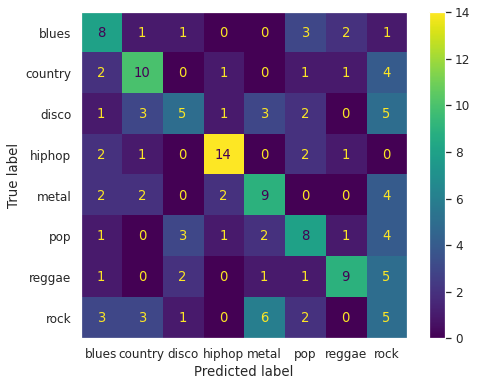

Accuracy  = 0.4444444444444444
F1 score  = 0.44934056502683956
Precision = 0.4661424803839665
Recall    = 0.4444444444444444


In [57]:
# 300 dimensional word vectors
pipe = Pipeline([
    ('vec', LyricsVectorizer("300d")),
    ('clf', XGBClassifier())
])

params = {
    'vec__method':["mean", "sum"],
    'clf__max_depth': [3, 6, 10],
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__learning_rate': [0.01, 0.1, 0.2],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train, y_train_enc)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test, y_test, label_enc)